In [1]:
# import matplotlib as mpl
# # Use the pgf backend (must be set before pyplot imported)
# mpl.use('pgf')

from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binomtest, sem, barnard_exact, fisher_exact
import seaborn as sns
import pickle

mean = np.mean
from functools import cache
from sklearn.metrics import roc_curve, roc_auc_score

algorithms = ['detectron_entropy',
              'detectron_dis',
              'domain_dis',
              # 'domain_entropy',
              'ensemble', 'ensemble_entropy',
              'mahalanobis',
              'bbsd',
              # 'bbsd_max_softmax',
              # 'bbsd_max_logit', 'bbsd_entropy'
              ]

from scipy.interpolate import interp1d

In [2]:
# @cache
def get_exp(samples, shift, dataset='cifar', method='detectron'):
    # there is a bit of technical debt cleanup here :(
    r = []
    if method == 'detectron' and dataset == 'uci':
        method = 'detectron2'
    if method == 'detectron' and dataset == 'camelyon' and samples < 50:
        method = 'detectron/res'
    if method == 'domain':
        if dataset == 'uci':
            f = f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/{method}/*samples={samples}_shift={shift}.csv'
        else:
            f = f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/{method}/samples={samples}*_shift={shift}.csv'
    else:
        f = f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/{method}/*samples={samples}_shift={shift}.csv'
    return pd.concat([pd.read_csv(file).iloc[-1:] for file in glob(f)]).reset_index(drop=True)

In [3]:
def get_baseline(df, n):
    baseline = df.query(f'test_samples == {n}').query('shift==False').test_reject.mean()
    return baseline


def barnard(rp, rq, n):
    return barnard_exact([[rq, rp], [n - rq, n - rp]], alternative='greater').pvalue


def fisher(rp, rq, n):
    return fisher_exact([[rq, rp], [n - rq, n - rp]], alternative='greater')[1]


def binomial(rp, rq, n):
    return binomtest(k=rq, n=n, p=rp / n, alternative='greater').pvalue


def load_preds(seed, samples, shift, method='detectron'):
    if method == 'detectron':
        method = 'detectron2'
    f = f'../checkpoints/uci/{method}/preds_{seed=}_{samples=}_{shift=}.pkl'
    return pickle.load(open(f, 'rb'))

In [4]:
def pvals(tru, fls, n):
    func = fisher if n > 50 else barnard
    x = []
    for t in tru:
        for f in fls:
            x.append(func(round(f * n), round(t * n), n))
    td = np.array(x)

    x = []

    for i, _ in enumerate(fls):
        for j, _ in enumerate(fls):
            if i == j:
                continue
            x.append(func(round(fls[i] * n), round(fls[j] * n), n))
    fd = np.array(x)
    return td, fd

In [5]:
from shift_detection.shiftdetection import ensemble_entropy, entropy
from scipy.stats import ks_2samp
import torch


def numpy_entropy(x):
    # softmax
    eps = 1e-8
    x = np.stack(x).mean(0)
    return -(x * np.log(x + eps) + (1 - x) * np.log(1 - x + eps))


def entropy_pvals(samples, hypothesis=True, method='detectron'):
    pvals = []
    for i in range(10):
        for j in range(10):
            if hypothesis == False and i == j:
                continue
            pval = ks_2samp(numpy_entropy((load_preds(i, samples, hypothesis, method=method))),
                            numpy_entropy((load_preds(j, samples, False, method=method)))).pvalue
            pvals.append(pval)
    return np.array(pvals)


# @cache
def detectron_pval(samples, dataset='cifar', method='detectron_dis'):
    if 'dis' in method:
        method = method.split('_')[0]
        fls = list(get_exp(samples, False, dataset, method=method).test_reject)
        tru = list(get_exp(samples, True, dataset, method=method).test_reject)
        s, n = pvals(tru, fls, samples)
    elif 'entropy' in method:
        if dataset == 'uci':
            method = method.split('_')[0]
            s = entropy_pvals(samples, True, method=method)
            n = entropy_pvals(samples, False, method=method)
        else:
            df = pd.read_json(f'../checkpoints/{dataset}/entropy.json')
            s = np.array(df.query(f'samples=={samples} and shift==True').iloc[0].pvals)
            n = np.array(df.query(f'samples=={samples} and shift==False').iloc[0].pvals)
    else:
        raise ValueError('method must be dis or entropy not {}'.format(method))
    return s, n


# @cache
def query_pvals(algo, samples, dataset='cifar'):
    global em
    if 'detectron' in algo or 'domain' in algo:
        return detectron_pval(samples, dataset, algo)
    df = em.query(f'algorithm=="{algo}" and test_samples=={samples}')
    s = np.array(df.query('shift==True').pvals)
    n = np.array(df.query('shift==False').pvals)
    if algo == 'bbsd':
        s = np.array([min(x) for x in s])
        n = np.array([min(x) for x in n])
    return s, n

In [6]:
import random


def pval_roc_curve(s, n):
    y_score = (1 - np.concatenate([s, n]))
    y_true = np.concatenate([np.ones(len(s)), np.zeros(len(n))])
    fpr, tpr, thr = roc_curve(y_true=y_true, y_score=y_score)
    return fpr, tpr, thr


def metric_intervals(s, n):
    y_score = (1 - np.concatenate([s, n]))
    y_true = np.concatenate([np.ones(len(s)), np.zeros(len(n))])
    aucs = []
    tds = []
    for i in range(100):
        rng = random.Random(i)
        idx = rng.sample(range(len(y_true)), (len(y_true) * 9) // 10)
        fpr, tpr, thr = roc_curve(y_true=y_true[idx], y_score=y_score[idx])
        func = interp1d(fpr, tpr)
        td = func(0.05)
        auc = np.trapz(tpr, fpr)
        aucs.append(auc)
        tds.append(td)
    return [np.mean(aucs), np.std(aucs)], [np.mean(tds), np.std(tds)]

In [156]:
res = pd.read_json('../checkpoints/camelyon/entropy.json')

In [157]:
s = res.query('shift==True and samples==50').iloc[0].pvals
n = res.query('shift==False and samples==50').iloc[0].pvals

In [158]:
metric_intervals(s, n)

([0.9968741050157339, 0.0006870409367293351],
 [0.9764321723433226, 0.0049426700835172605])

In [11]:
st = ''
dataset = 'camelyon'
em = pd.read_json(f'../tables/{dataset}/shift.json')
try:
    mah = pd.read_csv(f'../tables/{dataset}/mahal.csv')
    em = pd.concat([em, mah])
except FileNotFoundError:
    print('no mahalanobis results for dataset {}'.format(dataset))
#
try:
    res = pd.read_json(f'../tables/{dataset}/two_sample_results.json').to_dict()
except:
    res = {algo: {} for algo in algorithms}
res = {algo: {} for algo in algorithms}
# del res['detectron_entropy']

d = {}
rng = [10, 20, 50]
for algorithm in algorithms:

    print(algorithm)
    for samples in rng:
        if algorithm in res and samples in res[algorithm]:
            td = res[algorithm][samples]['td']
            auc = res[algorithm][samples]['auc']
        else:
            if algorithm not in res:
                res[algorithm] = {}
            try:
                s, n = query_pvals(algorithm, samples, dataset=dataset)
                auc, td = metric_intervals(s, n)
            except:
                auc, td = [0, 0], [0, 0]
            # fpr, tpr, thr = roc_curve(y_score=(1 - np.concatenate([s, n])),
            #                           y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
            # func = interp1d(fpr, tpr)
            # td = func(0.05)
            # td = 100 * td, 100 * (func(0.06) - func(0.04)) / 2
            # auc = np.trapz(tpr, fpr)
            res[algorithm][samples] = {'td': td, 'auc': auc}

        if algorithm in d:
            d[algorithm][0].append(td)
            d[algorithm][1].append(auc)
        else:
            d[algorithm] = ([td], [auc])

        print(f'${td[0]:.1f} \pm {td[1]:.1f}$ & ${auc[0]:.1f} \pm {auc[1]:.1f}$', end=' & ')

    print('\n')

# pd.DataFrame(res).to_json(f'../tables/{dataset}/two_sample_results.json')

detectron_entropy
$0.1 \pm 0.0$ & $0.5 \pm 0.0$ & $0.3 \pm 0.0$ & $0.8 \pm 0.0$ & $1.0 \pm 0.0$ & $1.0 \pm 0.0$ & 

detectron_dis
$0.5 \pm 0.0$ & $0.8 \pm 0.0$ & $0.8 \pm 0.0$ & $1.0 \pm 0.0$ & $0.8 \pm 0.0$ & $0.9 \pm 0.0$ & 

domain_dis
$0.2 \pm 0.0$ & $0.6 \pm 0.0$ & $0.0 \pm 0.0$ & $0.5 \pm 0.0$ & $0.0 \pm 0.0$ & $0.5 \pm 0.0$ & 

ensemble
$0.2 \pm 0.0$ & $0.6 \pm 0.0$ & $0.2 \pm 0.1$ & $0.7 \pm 0.0$ & $0.6 \pm 0.0$ & $0.9 \pm 0.0$ & 

ensemble_entropy
$0.4 \pm 0.1$ & $0.8 \pm 0.0$ & $0.8 \pm 0.0$ & $0.9 \pm 0.0$ & $1.0 \pm 0.0$ & $1.0 \pm 0.0$ & 

mahalanobis
$0.2 \pm 0.0$ & $0.7 \pm 0.0$ & $0.4 \pm 0.0$ & $0.8 \pm 0.0$ & $0.9 \pm 0.0$ & $1.0 \pm 0.0$ & 

bbsd
$0.1 \pm 0.0$ & $0.7 \pm 0.0$ & $0.2 \pm 0.0$ & $0.8 \pm 0.0$ & $0.8 \pm 0.0$ & $1.0 \pm 0.0$ & 



In [8]:
def make_table(td10, td20, td50, auc10, auc20, auc50, dataset='cifar'):
    template = f"""
    \\multirow{{6}}{{*}}{{\\STAB{{\\rotatebox[origic]{{90}}{{\\small {dataset}}}}}}} & \\multirow{{2}}{{*}}{{$10$}}  & {{\\small TPR@5}} & {td10}
        \\\\
                                                                                     &                               & {{\\small AUC}} & {auc10}
        \\\\
                                                                                     & \\multirow{{2}}{{*}}{{$20$}}  & {{\\small TPR@5}} & {td20}
        \\\\
                                                                                     &                               & {{\\small AUC}} & {auc20}
        \\\\
                                                                                     & \\multirow{{2}}{{*}}{{$50$}}  & {{\\small TPR@5}} & {td50}
        \\\\
                                                                                     &                               & {{\\small AUC}} & {auc50}
    """
    print(template)

In [9]:
def argmax_w_tolerance(arr, tolerance):
    """
    finds all indexes with in tolerance of the max value in arr
    """
    arr = np.array(arr)
    max_idx = np.argmax(arr)
    return set(np.where(np.abs(arr - arr[max_idx]) < tolerance)[0]), max_idx

In [19]:
argmax_w_tolerance(x, 2.5 / 100)

set()

In [12]:
metrics = {}
for samples in rng:
    for metric in ['td', 'auc']:
        s = []
        x = [res[algorithm][samples][metric][0] for i, algorithm in enumerate(reversed(algorithms))]
        best_vals = argmax_w_tolerance(x, 2.5 / 100)
        for i, algorithm in enumerate(reversed(algorithms)):
            x = res[algorithm][samples][metric]
            if isinstance(x, list):
                if i not in best_vals[0]:
                    x = f'${x[0]:.3f} \pm {x[1]:.3f}$'
                elif i == best_vals[-1]:
                    x = f'$\\mathbf{{{x[0]:.3f} \pm {x[1]:.3f}}}$'
                else: # close to best
                    x = f'$\\underline{{{x[0]:.3f} \pm {x[1]:.3f}}}$'
            s.append(x)
        metrics[f'{metric}{samples}'] = ' & '.join(s).replace('0.', '.')

d_name = {'cifar': 'CIFAR-10/10C', 'camelyon': 'CAMELYON 17', 'uci': 'UCI Heart Disease'}[dataset]
make_table(**metrics, dataset=d_name)


    \multirow{6}{*}{\STAB{\rotatebox[origic]{90}{\small CAMELYON 17}}} & \multirow{2}{*}{$10$}  & {\small TPR@5} & $.090 \pm .020$ & $.162 \pm .017$ & $.411 \pm .056$ & $.180 \pm .016$ & $.165 \pm .037$ & $\mathbf{.465 \pm .029}$ & $.071 \pm .009$
        \\
                                                                                     &                               & {\small AUC} & $.691 \pm .012$ & $.666 \pm .012$ & $\mathbf{.844 \pm .010}$ & $.579 \pm .014$ & $.595 \pm .013$ & $\underline{.820 \pm .009}$ & $.531 \pm .015$
        \\
                                                                                     & \multirow{2}{*}{$20$}  & {\small TPR@5} & $.236 \pm .028$ & $.398 \pm .040$ & $.772 \pm .031$ & $.221 \pm .055$ & $.020 \pm .005$ & $\mathbf{.811 \pm .024}$ & $.343 \pm .017$
        \\
                                                                                     &                               & {\small AUC} & $.805 \pm .011$ & $.814 \pm .011$ & $\under


    \multirow{6}{*}{\STAB{\rotatebox[origic]{90}{\small Camelyon 17}}} & \multirow{2}{*}{$10$}  & {\small TPR@5} & $.090 \pm .020$ & $.162 \pm .017$ & $.411 \pm .056$ & $.180 \pm .016$ & $.000 \pm .000$ & $\mathbf{.465 \pm .029}$ & $.071 \pm .009$
        \\
                                                                                     &                               & {\small AUC} & $.691 \pm .012$ & $.666 \pm .012$ & $\mathbf{.844 \pm .010}$ & $.579 \pm .014$ & $.000 \pm .000$ & $\underline{.820 \pm .009}$ & $.531 \pm .015$
        \\
                                                                                     & \multirow{2}{*}{$20$}  & {\small TPR@5} & $.236 \pm .028$ & $.398 \pm .040$ & $.772 \pm .031$ & $.221 \pm .055$ & $.000 \pm .000$ & $\mathbf{.811 \pm .024}$ & $.343 \pm .017$
        \\
                                                                                     &                               & {\small AUC} & $.805 \pm .011$ & $.814 \pm .011$ & $\under

In [22]:
pd.DataFrame(res).to_json(f'../tables/{dataset}/two_sample_results.json')

In [23]:
format_label = {'detectron_dis': '\\textbf{Detectron (Dis)}',
                'mahalanobis': 'Mahalanobis',
                'detectron_entropy': '\\textbf{Detectron (Entropy)}',
                'domain_dis': '\\textbf{Domain Cls (Dis)}',
                'domain_entropy': '\\textbf{Domain Cls (Entropy)}',
                'ensemble_entropy': 'Ensemble (Entropy)',
                'bbsd_max_softmax': 'BBSD (Max Softmax)',
                'bbsd': 'BBSD (Bonferroni)',
                'bbsd_max_logit': 'BBSD (Max Logit)',
                'bbsd_entropy': 'BBSD (Entropy)',
                'ensemble': 'Ensemble (Dis)'}

In [24]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
    'font.size': 18}
)

algo='detectron_entropy' samples=10 td=8.50+-0.04 auc=0.728
algo='detectron_dis' samples=10 td=45.25+-0.01 auc=0.819
algo='ensemble' samples=10 td=18.10+-0.02 auc=0.580
algo='ensemble_entropy' samples=10 td=46.00+-0.09 auc=0.845
algo='mahalanobis' samples=10 td=16.00+-0.00 auc=0.668
algo='bbsd' samples=10 td=10.00+-0.02 auc=0.693
algo='detectron_entropy' samples=20 td=43.08+-0.02 auc=0.827
algo='detectron_dis' samples=20 td=80.00+-0.00 auc=0.960
algo='ensemble' samples=20 td=20.00+-0.07 auc=0.662
algo='ensemble_entropy' samples=20 td=79.00+-0.04 auc=0.947
algo='mahalanobis' samples=20 td=44.00+-0.07 auc=0.813
algo='bbsd' samples=20 td=25.00+-0.03 auc=0.805
algo='detectron_entropy' samples=50 td=93.12+-0.00 auc=0.971
algo='detectron_dis' samples=50 td=82.00+-0.00 auc=0.946
algo='ensemble' samples=50 td=57.00+-0.02 auc=0.864
algo='ensemble_entropy' samples=50 td=96.00+-0.01 auc=0.996
algo='mahalanobis' samples=50 td=91.00+-0.03 auc=0.979
algo='bbsd' samples=50 td=81.00+-0.06 auc=0.959


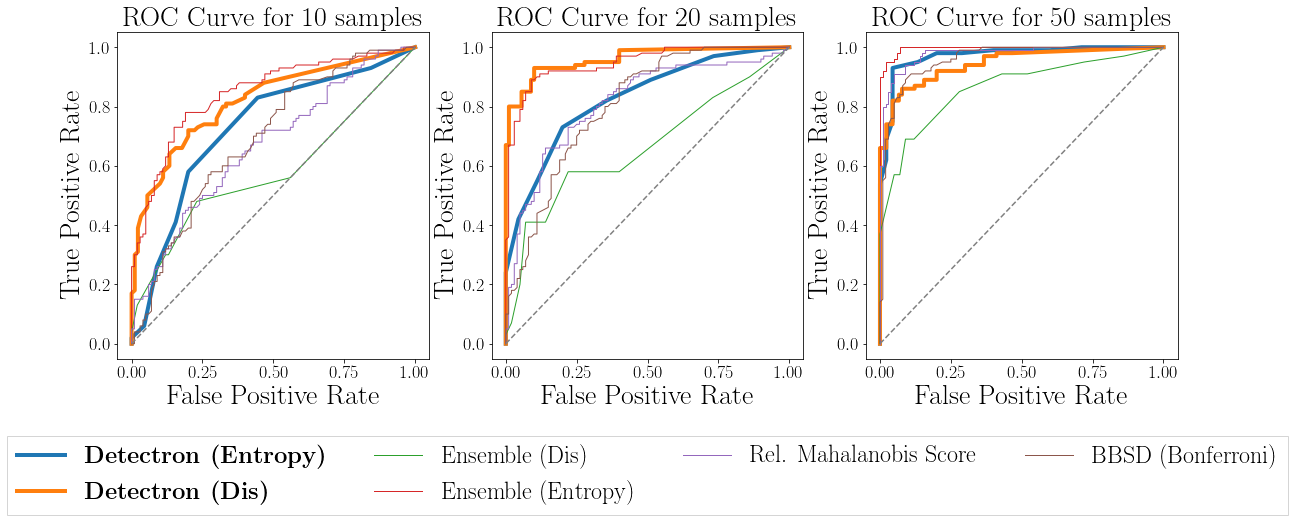

<Figure size 432x288 with 0 Axes>

In [146]:
fig, axes = plt.subplots(1, len(rng), figsize=(6 * len(rng) + 1, 6), squeeze=False)
for samples, ax in zip(rng, axes.ravel()):

    for algo in algorithms:
        try:
            s, n = query_pvals(algo, samples, dataset=dataset)
        except ValueError:
            continue

        fpr, tpr, thr = roc_curve(y_score=(1 - np.concatenate([s, n])),
                                  y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
        auc = np.trapz(tpr, fpr)

        label = format_label[algo]
        if 'domain' in algo:
            linewidth = 2
        elif 'detectron' not in algo:
            linewidth = 1
        else:
            linewidth = 4
        ax.plot(fpr, tpr, label=label if samples == 20 else None, linewidth=linewidth)
        func = interp1d(fpr, tpr)
        td = func(0.05)
        td = td, (func(0.055) - func(0.045))
        print(f'{algo=} {samples=} td={100 * td[0]:.2f}+-{td[1]:.2f} auc={auc:.3f}')
        # ax.plot(fd, td, 'o', color='black')

    ax.set_xlabel('False Positive Rate', fontdict={'fontsize': 28})
    ax.set_ylabel('True Positive Rate', fontdict={'fontsize': 28})
    if samples == 20:
        ax.legend(fontsize=24, loc='upper center',
                  bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4)
    ax.set_title(f'ROC Curve for {samples} samples', fontdict={'fontsize': 28})
    ax.plot([0, 1], [0, 1], '--', color='gray')

plt.show()
plt.savefig(f'/voyager/projects/tomginsberg/{dataset}_roc.pdf', bbox_inches='tight')
# fig.tight_layout()
# fig.savefig(f'/voyager/projects/tomginsberg/roc_curves_{dataset=}.pgf', bbox_inches='tight', format='pgf')

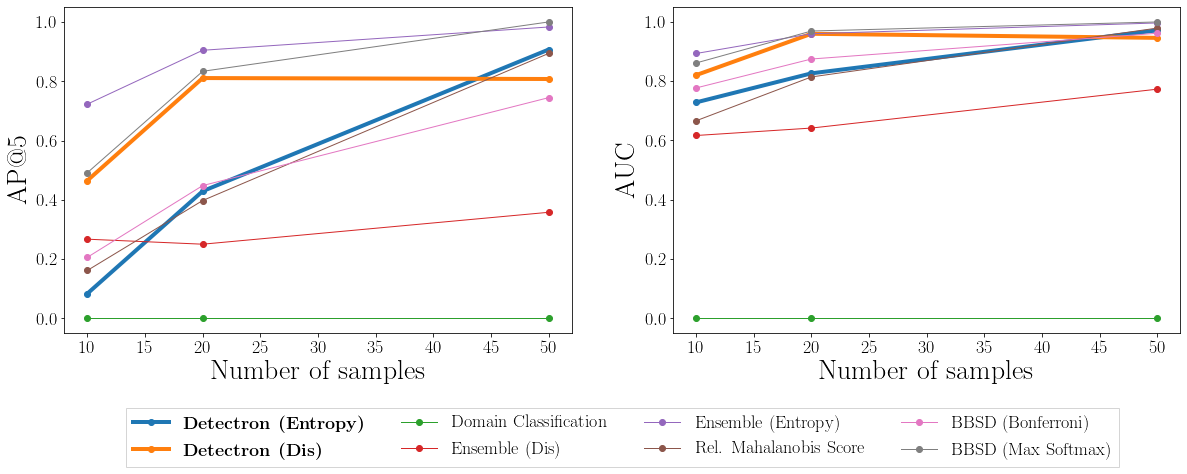

In [99]:
format_label = {'detectron_dis': '\\textbf{Detectron (Dis)}',
                'mahalanobis': 'Rel. Mahalanobis Score',
                'detectron_entropy': '\\textbf{Detectron (Entropy)}',
                'domain_dis': '{Domain Classification}',
                'domain_entropy': '\\textbf{Domain Cls (Entropy)}',
                'ensemble_entropy': 'Ensemble (Entropy)',
                'bbsd_max_softmax': 'BBSD (Max Softmax)',
                'bbsd': 'BBSD (Bonferroni)',
                'bbsd_max_logit': 'BBSD (Max Logit)',
                'bbsd_entropy': 'BBSD (Entropy)',
                'ensemble': 'Ensemble (Dis)'}
rng = [10, 20, 50]
fig, axes = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)

for algo in d:
    if 'detectron' in algo:
        linewidth = 4
    else:
        linewidth = 1
    try:
        axes[0][0].plot(rng, np.array(d[algo][0])[:, 0], '-o', label=format_label[algo], linewidth=linewidth)
        axes[0][0].set_xlabel('Number of samples', fontdict={'fontsize': 28})
        axes[0][0].set_ylabel('AP@5', fontdict={'fontsize': 28})
        axes[0][1].plot(rng, np.array(d[algo][1])[:, 0], '-o', linewidth=linewidth, label=None)
        axes[0][1].set_xlabel('Number of samples', fontdict={'fontsize': 28})
        axes[0][1].set_ylabel('AUC', fontdict={'fontsize': 28})
    except ValueError:
        continue

axes[0][0].legend(loc='upper center',
                  bbox_to_anchor=(1.1, -.2),
                  fancybox=False, shadow=False, ncol=4)
plt.savefig(f'/voyager/projects/tomginsberg/{dataset}_results.pdf', bbox_inches='tight')

In [7]:
from data.cifar10 import CIFAR10DataModule
from models import pretrained
from shift_detection.shiftdetection import ShiftDetection, entropy, ensemble_entropy

dm = CIFAR10DataModule(test_samples='all', batch_size=1024, shift=True, negative_labels=False)

models, names = pretrained.all_camelyon_model(return_names=True, device='cuda:2', eval_=True)
em = ShiftDetection(models=models, model_names=names, datamodule=dm, df_path='../tables/camelyon',
                    logit_path='../logits/camelyon', load_logits=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.98it/s]


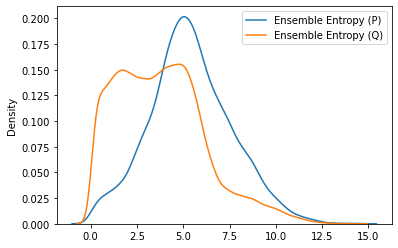

In [13]:
sns.kdeplot(em.p_data[0][0].max(1).values, label='Ensemble Entropy (P)')
sns.kdeplot((em.q_data[0][0]).max(1).values, label='Ensemble Entropy (Q)')
plt.legend()

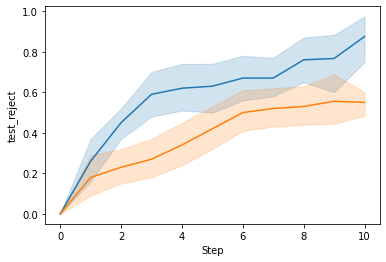

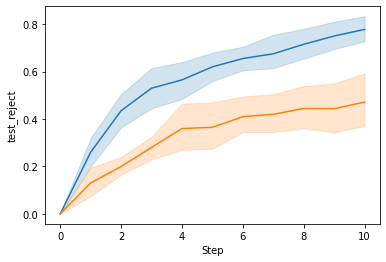

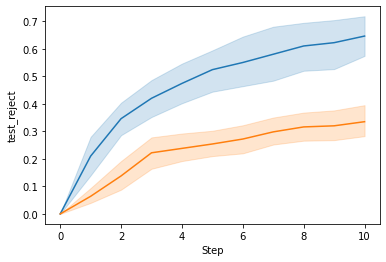

In [9]:
dataset = 'camelyon'
method = 'detectron'
for samples in [10, 20, 50]:
    for shift in [True, False]:
        data = pd.concat([pd.read_csv(x) for x in glob(
            f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/{method}/*samples={samples}_shift={shift}.csv')]).reset_index(
            drop=True)
        sns.lineplot(x='Step', y='test_reject', data=data)
    plt.show()

In [89]:
query_pvals('detectron_dis', 10, 'camelyon')

(array([4.36404919e-04, 2.09320503e-02, 1.05857849e-04, 4.36404919e-04,
        1.75827776e-03, 6.38961792e-03, 2.00271606e-05, 1.75827776e-03,
        6.38961792e-03, 1.07486681e-01, 3.46536108e-03, 7.55097209e-02,
        1.28841400e-03, 3.46536108e-03, 1.13899913e-02, 3.11548077e-02,
        2.01225281e-04, 1.13899913e-02, 3.11548077e-02, 3.36677280e-01,
        4.36404919e-04, 2.09320503e-02, 1.05857849e-04, 4.36404919e-04,
        1.75827776e-03, 6.38961792e-03, 2.00271606e-05, 1.75827776e-03,
        6.38961792e-03, 1.07486681e-01, 2.06947327e-02, 2.61720658e-01,
        5.90896606e-03, 2.06947327e-02, 4.72331257e-02, 1.10316137e-01,
        9.08873627e-04, 4.72331257e-02, 1.10316137e-01, 1.00000000e+00,
        4.36404919e-04, 2.09320503e-02, 1.05857849e-04, 4.36404919e-04,
        1.75827776e-03, 6.38961792e-03, 2.00271606e-05, 1.75827776e-03,
        6.38961792e-03, 1.07486681e-01, 1.17280058e-01, 1.00000000e+00,
        4.74390013e-02, 1.17280058e-01, 2.61737331e-01, 4.119014

In [116]:
df = pd.read_json(f'../checkpoints/{dataset}/entropy.json')

In [117]:
df

,shift,samples,pvals
0,True,10,"[0.7869297885000001, 0.7869297885000001, 0.786..."
1,True,20,"[0.33559098130000004, 0.0810577116, 0.00396729..."
2,True,50,"[0.000246024, 0.0028349806, 1.38679e-05, 0.039..."
3,False,10,"[0.9944575548000001, 0.7869297885000001, 0.052..."
4,False,20,"[0.8319696108, 0.1745330057, 0.9831368773, 0.1..."
5,False,50,"[0.3959398632, 0.716646844, 0.1123852485, 0.11..."
